In [12]:
#import os
import sqlite3
from datetime import datetime
import warnings
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
#from matplotlib.colors import LinearSegmentedColormap
#from matplotlib import colors as mcolors
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster import hierarchy
from statsmodels.nonparametric.kernel_regression import KernelReg


# Suppression warnings KMeans
warnings.filterwarnings(action='ignore', 
                        message='KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.')
warnings.filterwarnings(action='ignore', 
                        message='KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.')
warnings.filterwarnings(action='ignore', 
                        message = 'DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()')


# Liste des fonctions

def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)
        
def f_clusters_transform (df):
    """
    df : dataframe pandas
    """
    data = df.values.T
    names = df.columns
    return(data, names)



def f_clusters_coude (df, n_init:int=100, plage:tuple = (2,20)) :
    """
    df : dataframe à entrer
    n_init : nombre de configuration de départ pour les centroïdes
    plage : plage de mesure du k optimal
    """   
    
    # Transformation du dataframe d'entrée pour analyse
    data, names = f_clusters_transform(df)
    
    plage = list(plage)
    
    if plage[1] > data.shape[0]:
        plage[1] = data.shape[0]

    k_mesure = range(plage[0], plage[1])

    results = pd.DataFrame(index=k_mesure, columns=["inertia"], dtype='float')

    for k in tqdm (k_mesure,
                    desc="Calcul de l'inertie",  
                    ascii=False, ncols=100) :
        km = KMeans(n_clusters=k, n_init=n_init) 
        km = km.fit(data)
        inertie = km.inertia_
        results.loc[k,"inertia"] = inertie

        
    # Calcul des dérivées premières et secondes.
    # yb - ya / xb - xa
    # On prend en compte la pente de la droite qui suit le point en quaestion
    results["deriv"] = np.NaN
    for k in results.index.values:
        try : 
            results.loc[k, "deriv"] = results.loc[k+1, "inertia"] - results.loc[k, "inertia"]
        except:
            pass

    results["deriv_2"] = np.NaN
    for k in results.index.values:
        try : 
            results.loc[k, "deriv_2"] = results.loc[k+1, "deriv"] - results.loc[k, "deriv"]
        except:
            pass

    median = results.loc[10:,"deriv_2"].quantile(0.5)
    Q1 = results.loc[10:,"deriv_2"].quantile(0.25)
    Q3 = results.loc[10:,"deriv_2"].quantile(0.75)
    
    mean = results.loc[10:,"deriv_2"].mean()
    sigma = results.loc[10:,"deriv_2"].std()
      
    best_k = results[results.deriv_2 < (mean + 2*sigma)].first_valid_index()
        
        
    fig, ax1 = plt.subplots(figsize=(12,8))

    fig.suptitle(f"Nombre de cluster optimal estimé : {best_k}")

    ax1.plot(results.inertia)
    ax1.set_xlabel('nombre de clusters')
    ax1.set_ylabel('inertie')
    ax1.legend(["inertie"], bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax1.scatter(best_k, results.loc[best_k,"inertia"],s=100, c='red', marker='X')
    ax1.axvline(x=best_k, color='gray',linestyle='--')

    ax2 = plt.axes([0,0,1,1])
    # Manually set the position and relative size of the inset axes within ax1
    ip = InsetPosition(ax1, [0.45,0.45,0.5,0.5])
    ax2.set_axes_locator(ip)
    # Mark the region corresponding to the inset axes on ax1 and draw lines
    # in grey linking the two axes.
    ax2.plot(results.deriv_2)
    ax2.set_xlabel('nombre de clusters')
    ax2.set_ylabel('dérivée 2nde')
    ax2.axvline(x=best_k, color='gray',linestyle='--')
    ax2.fill_between(np.arange(1,plage[1]), 
                     mean + 2*sigma, 
                     mean - 2*sigma, 
                     color='lightcoral')

    return best_k, results
    
    
    
def f_clusters_fit (df, k:int = 4, n_init:int = 100, max_iter:int = 2000):
    
    """
    Entrainement et affichage de la distribution dans les clusters
    return :
    - cluster_table : df bss - cluster - MSE
    - df_clusters_centers : df série temporelle des clusters
    - metric : "euclidean" / "dtw" / "softdtw"
    """
    
    data, names = f_clusters_transform(df)
    # Initilialisation du modèle
    km = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, random_state=2022)
    # Entraînement du modèle
    km.fit(data)
    # Définition des numéros de cluster
    labels = km.labels_+1 
    # Profils des clusters
    cluster_centers = np.array(km.cluster_centers_)
    df_cluster_centers = pd.DataFrame(cluster_centers.T, index=df.index)
    for cluster in range(df_cluster_centers.shape[1]):
        df_cluster_centers.rename(columns = {cluster:f"cluster_{cluster+1}"}, inplace=True)
    
    # Création du dataframe de résultats
    cluster_table = pd.DataFrame()
    cluster_table["code_bss"] = names
    cluster_table.set_index("code_bss", inplace=True)
    cluster_table["cluster"] = labels
    for piezo in cluster_table.index :
        cluster_table.loc[piezo, "MSE"] = mean_squared_error(df.loc[:,piezo], cluster_centers[cluster_table.loc[piezo, "cluster"]-1])
    
    return cluster_table, df_cluster_centers

def f_plot_clusters (df, cluster_table, cluster_centers, plot_mean:bool = True):
    
    data, names = f_clusters_transform (df)
    
    labels = cluster_table["cluster"]
    
    fig, axs = plt.subplots(len(set(labels)),1,figsize=(20,4*cluster_centers.shape[1]))
    row_i=0

    for label in set(labels):
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i].plot(df.iloc[:,i],alpha=0.4)
        if plot_mean:
            axs[row_i].plot(cluster_centers.iloc[:,label-1],c="red")
        axs[row_i].set_title("Cluster "+str(row_i+1))
        row_i+=1
    plt.show()
    
def f_plot_all (df, cluster_table, df_cluster_centers) :

    if df.shape[1]%4 == 0:
        nbre_lignes = df.shape[1]//4
    else : 
        nbre_lignes = df.shape[1]//4 + 1

    fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
    #fig.suptitle('Series')
    for i in range(nbre_lignes):
        for j in range(4):
            if i*4+j+1>df.shape[1]: # pass the others that we can't fill
                continue
            axs[i, j].plot(df.iloc[:,i*4+j])
            axs[i, j].plot(df_cluster_centers.iloc[:,cluster_table.iloc[i*4+j,0]-1])
            
            axs[i, j].set_title(df.columns[i*4+j] + f" - MSE = {round(cluster_table.loc[df.columns[i*4+j],'MSE'],2)}")
            
    plt.show()
    

def f_MSEmax (cluster_table):
    # Calcul de MSEmin

    Q1 = cluster_table["MSE"].quantile(0.25, "higher")
    Q3 = cluster_table["MSE"].quantile(0.75, "lower")

    # Ecart inter-quartile
    IQM = abs(Q3-Q1)

    # Seuil minimal de conservation des chroniques (Q3+1.5*IQM)

    MSEmin = Q3+1.5*IQM
    return MSEmin

# Chargement des données

In [13]:
region = "FRANCE"

In [14]:
# Import du csv et conversion en dataframe
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
data = pd.read_csv(f"./data/{region}.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

print(f"Il y a {data.shape[1]} piezos pour le clustering dans le dataframe.")

Il y a 45 piezos pour le clustering dans le dataframe.


# Analyse du nombre optimal de clusters

In [7]:
best_k, results = f_clusters_coude(data, n_init=150, plage=(1,47))

TypeError: 'tuple' object does not support item assignment

# Création des clusters KMeans

In [ ]:
# Choix du nombre de clusters à créer
nbre_clusters = 5

In [ ]:
# Entrainement
cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters, n_init = 2000, max_iter = 500)

# répartition des piezos dans les clusters
sns.countplot(data = cluster_table, x = "cluster")

## Affichage des clusters

In [ ]:
f_plot_clusters(data, cluster_table, cluster_centers)
#cluster_table.groupby("cluster").mean()

In [ ]:
#f_plot_all(data, cluster_table, cluster_centers)

In [ ]:
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{index+1}"}, inplace=True)  

cluster_centers

In [ ]:
cluster_table

## Renommage des noms de cluster

In [ ]:
clusters =  list(range(1, nbre_clusters +1))
clusters_by_count = cluster_table.cluster.value_counts().index.to_list()

new_clusters = []

ch = "A"

for number in clusters_by_count :
    new_clusters.append(chr(ord(ch)+number-1))
    
# Renommage des clusters avec des lettres et par fréquence

# - Cluster table
cluster_table.replace(list(map(int, clusters)), new_clusters, inplace=True)

# - Cluster centers
dict_rename = dict(zip(map(str, clusters), new_clusters))
cluster_centers.rename(columns=dict_rename, inplace=True)

## Enregistrement des profils des clusters

In [ ]:
cluster_centers.to_csv(f"./data/{region}_clusters.csv")
cluster_centers

### Ajout à la bdd

In [ ]:
# Nom de la table
champ = "cluster_kmeans_France"

In [ ]:
# Création de la table
requete = f"""
                    ALTER TABLE data_piezo
                    ADD {champ} VARCHAR(6) DEFAULT NULL
                    """
f_requete_sql(requete)

In [ ]:
# Liaison tables clusters région avec clusters France
requete = """
        select * from flagship_piezo
"""

flagships = f_requete_sql(requete)
df = pd.DataFrame(index = [flagships[index][0] for index in range(len(flagships))])
df["new_cluster"] = cluster_table.cluster.values

In [ ]:
# Création de listes de nuéro de cluster avec le nom des piezos
# Ajout dans la bdd
for label in set(df.new_cluster):
    cluster = tuple(df.loc[df.new_cluster == label, 'new_cluster'].index.to_list())
    requete = f"""
        UPDATE data_piezo
        SET {champ} = '{region}_{label}'
        WHERE cluster_kmeans IN {cluster}
        """
    f_requete_sql(requete)

## Chronique caractéristique des clusters

In [ ]:
# Recherche du code_bss avec la valeur MSE la plus faible
liste_top_bss = []
for cluster in cluster_table.cluster.unique() :
    liste_top_bss.append(cluster_table.loc[cluster_table.cluster == cluster].sort_values("MSE").index[0])
df_top = pd.DataFrame(liste_top_bss, cluster_table.cluster.unique(), columns=["code_bss"])

df_top = df_top.sort_index()

In [ ]:
fig, axs = plt.subplots(len(df_top),1,figsize=(10,25))
for i in range (len(df_top)):
    cluster = df_top.index[i]
    bss = df_top.code_bss[cluster]
    axs[i].plot(cluster_centers.loc[:,cluster], 'red')
    axs[i].plot(data_opt.loc[:,bss])
    axs[i].set_title("Cluster "+ cluster + " - " + bss)    
                

### Ajout à la bdd

In [ ]:
code_cluster = tuple(region + "_" +  df_top.index)
code_bss = tuple(df_top.code_bss.values)
tableau = list(np.stack((code_cluster,code_bss), axis=1))
for index, line in enumerate(tableau):
    tableau[index] = tuple(line)

In [ ]:
# Création de la table
requete = f"""
            CREATE TABLE IF NOT EXISTS flagship_piezo (
            code_cluster VARCHAR(8) PRIMARY KEY ON CONFLICT IGNORE,
            code_bss VARCHAR(8)
            )
            """
f_requete_sql(requete)

In [ ]:
requete = f"INSERT INTO flagship_piezo (code_cluster, code_bss) VALUES (?,?)"

try:
    connexion = sqlite3.connect('../data/liste_piezos.db')
    curseur = connexion.cursor()
    print("Connexion réussie à SQLite")
    curseur.executemany(requete, tableau)
    connexion.commit()
    resultat = curseur.fetchall()
    curseur.close()
    connexion.close()
    print("Connexion SQLite est fermée")
except sqlite3.Error as error:
    print("Erreur lors du mis à jour dans la table : ", error)

# Dendrogramme 

## Analyse des découpages possibles

In [15]:
requete = """
Select * from flagship_piezo
WHERE code_cluster NOT LIKE 'FRANCE%'
"""

flagship_piezo = pd.DataFrame(f_requete_sql(requete), columns=["cluster_region", "code_bss"]).set_index("cluster_region")
flagship_piezo.head()

Connexion réussie à SQLite
Connexion SQLite est fermée


,code_bss
cluster_region,
ARA_A,06211X0041_P3CAPT
ARA_B,07223C0113_S
ARA_C,07208X0197_F1C
BFC_A,06003X0088_P
BFC_B,05794X0021_PZ1


In [16]:
df_chroniques_T = pd.merge(flagship_piezo, data.T, left_on="code_bss", right_index=True, how='inner').drop("code_bss", axis=1)
df_chroniques_T.head()

,2009-09-17,2009-09-24,2009-10-01,2009-10-08,2009-10-15,2009-10-22,2009-10-29,2009-11-05,2009-11-12,2009-11-19,...,2018-05-17,2018-05-24,2018-05-31,2018-06-07,2018-06-14,2018-06-21,2018-06-28,2018-07-05,2018-07-12,2018-07-19
cluster_region,,,,,,,,,,,,,,,,,,,,,
ARA_A,-1.084236,-1.130973,-1.181305,-1.220851,-1.246017,-1.213661,-1.242422,-1.015928,-0.979976,-1.059070,...,1.241825,0.979379,1.195088,1.432368,1.497081,0.903881,0.303491,-0.038048,-0.361611,-0.537773
ARA_B,-0.502191,-0.539431,-0.590635,-0.595290,-0.632529,-0.574342,-0.597617,-0.595290,-0.627874,-0.665113,...,-0.881566,-0.865274,-0.816398,-0.690715,-0.467279,-0.444005,-0.518483,-0.562705,-0.553395,-0.467279
ARA_C,2.265778,2.297523,2.302058,2.297523,2.320199,2.279383,2.329269,2.297523,2.283918,2.274848,...,-1.589015,-1.598085,-1.607155,-1.702391,-1.765882,-1.765882,-1.779487,-1.820303,-1.824838,-1.847513
BFC_A,-0.860052,-0.916339,-0.969739,-1.015923,-1.060663,-1.095301,-1.112620,-1.070766,-1.118393,-1.114063,...,0.674118,0.565875,0.505259,0.620718,0.503815,0.365264,0.242588,0.132901,0.026101,-0.100905
BFC_B,-1.510983,-1.573529,-1.607035,-1.602568,-1.618204,-1.591399,-1.595867,-1.537789,-1.540022,-1.557893,...,0.675876,0.644603,0.631201,0.649071,0.606629,0.494941,0.392188,0.381019,0.305071,0.246993


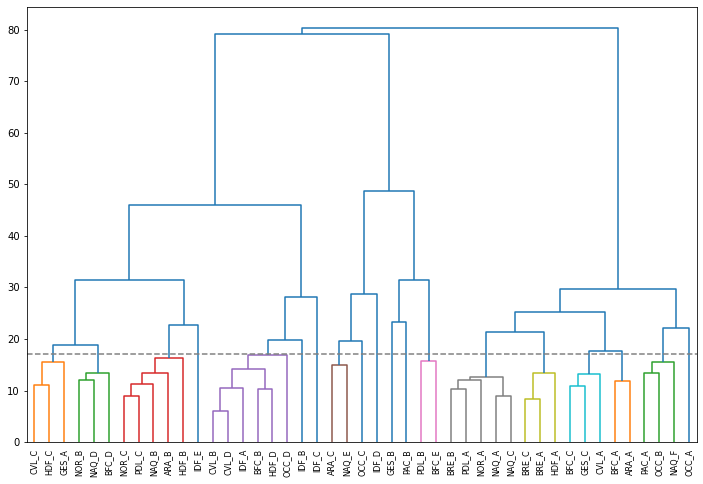

In [17]:
threshold = 17

Z = hierarchy.linkage(df_chroniques_T, method='ward', optimal_ordering=True)
plt.figure(figsize=(12,8))
dn = hierarchy.dendrogram(Z, 
                          labels=list(df_chroniques_T.index),
                          count_sort = 'descending',
                          distance_sort = 'ascending',
                          get_leaves =True,
                          show_leaf_counts = True,
                          color_threshold = threshold)
plt.axhline(y=threshold, color='grey', ls='--')
cluster_order = dn.get('ivl')
codes_couleur = dn.get('leaves_color_list')

In [18]:
# Création de la liste des niveaux de découpage
threshold_list = [60, 40, 25, 17]

## Renommage des clusters par niveau

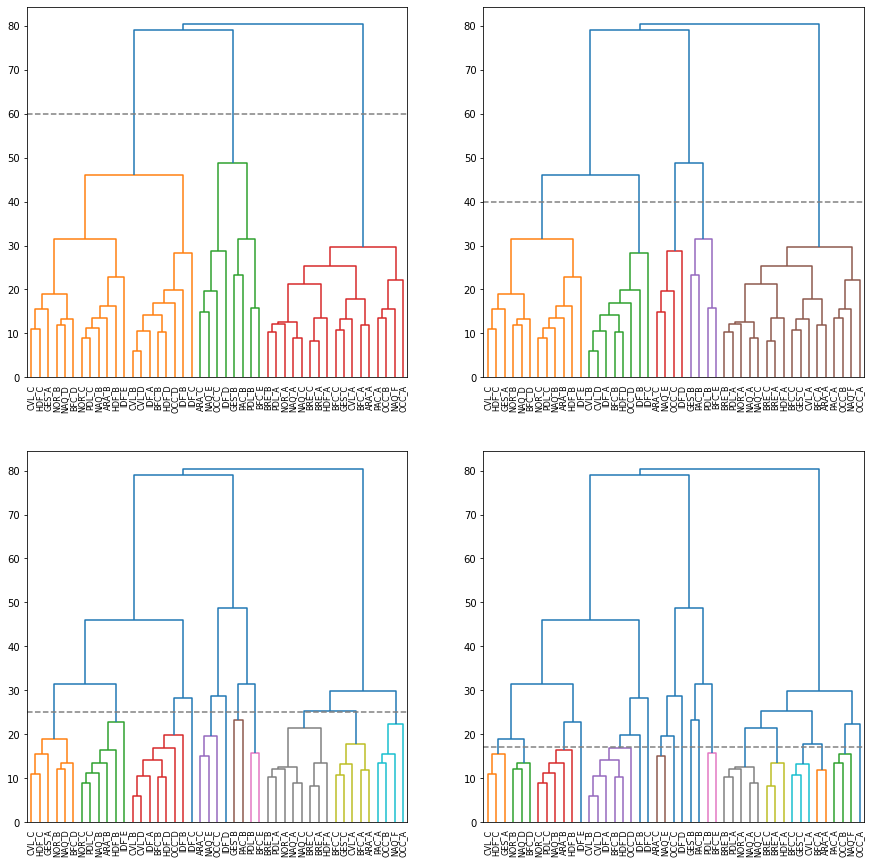

In [19]:
# Initialisation d'un dataframe
dendrogram_clusters = pd.DataFrame(index = cluster_order)
plt.figure(figsize=(15,15))
# Création des colonnes avec les codes couleur des clusters pour chaque ligne
for index, threshold in enumerate (threshold_list) :

    plt.subplot(2,2,index+1)
    dn = hierarchy.dendrogram(Z, 
                              labels=list(df_chroniques_T.index),
                              count_sort = 'descending',
                              distance_sort = 'ascending',
                              get_leaves =True,
                              show_leaf_counts = True,
                              color_threshold = threshold)
    dendrogram_clusters[index] = dn.get('leaves_color_list')
    
    plt.axhline(y=threshold, color='grey', ls='--')
    
plt.show()

In [20]:
# Renommage des C0 consécutifs avec colonnes parentes identiques. Ils ne doivent pas être regroupés.
for num, col in enumerate (dendrogram_clusters.columns[1:]):
    # Au moins 2 C0 consécutifs et colonnes précédentes identiques
    mask = (dendrogram_clusters[col] == dendrogram_clusters[col].shift(1)) & (dendrogram_clusters[col] == "C0") & (dendrogram_clusters[col-1] == dendrogram_clusters[col-1].shift(1))
    dendrogram_clusters.loc[mask, col] = "M"+str(num)

In [21]:
# Fonction de renommage
def f_rename_cluster (dendrogram_clusters_code, prev_cluster, col) :
    dendrogram_clusters_code.loc[((dendrogram_clusters_code[col-1] == prev_cluster) & (dendrogram_clusters_code[col] == cluster)), col] = prev_cluster*10 + index +1        


dendrogram_clusters_code = dendrogram_clusters.copy()

# Renommage première colonne
for index, color in enumerate (dendrogram_clusters_code[0].unique()):
    dendrogram_clusters_code.loc[dendrogram_clusters_code[0] == color, 0] = index+1
    
# Renommage pour les autres colonnes
for col in dendrogram_clusters_code.columns[1:] :
    # Regroupement en fonction des valeurs de la colonne précédente
    for prev_index, prev_cluster in enumerate(dendrogram_clusters_code[col-1].unique()):
        new_clusters = dendrogram_clusters_code.loc[dendrogram_clusters_code[col-1] == prev_cluster, col].unique()
        for index, cluster in enumerate(new_clusters) :
            f_rename_cluster (dendrogram_clusters_code, prev_cluster, col)

# Renommage des en-têtes            
columns_name = []         

for level in range(1,len(threshold_list)+1):
    columns_name.append(f"lvl_{level}")

dendrogram_clusters_code.columns = columns_name       


In [22]:
dendrogram_clusters_code

,lvl_1,lvl_2,lvl_3,lvl_4
CVL_C,1,11,111,1111
HDF_C,1,11,111,1111
GES_A,1,11,111,1111
NOR_B,1,11,111,1112
NAQ_D,1,11,111,1112
BFC_D,1,11,111,1112
NOR_C,1,11,112,1121
PDL_C,1,11,112,1121
NAQ_B,1,11,112,1121
ARA_B,1,11,112,1121


### Ajout à la base de données

In [76]:
for champ in dendrogram_clusters_code.columns :
    # Suppression du champ s'il existe déjà
    requete = f"""
            ALTER TABLE data_piezo
            DROP COLUMN 'FRANCE_{champ}'
            """
    try :  
        f_requete_sql(requete)
    except :
        pass
    
    # Création du champ
    requete = f"""
        ALTER TABLE data_piezo
        ADD COLUMN 'FRANCE_{champ}' VARCHAR(4)
        """
    f_requete_sql(requete)

    # Remplissage de la bdd
    for label in set(dendrogram_clusters_code[champ]):
        cluster = tuple(dendrogram_clusters_code.loc[dendrogram_clusters_code[champ] == label, champ].index.to_list())
        # Erreur si une seule valeur (format tuple qui finit par une virgule et provoque une erreur)
        if len(cluster) == 1:
            requete = f"""
                UPDATE data_piezo
                SET FRANCE_{champ} = '{region}_{label}'
                WHERE cluster_kmeans IN ('{cluster[0]}')
            """
        else :
            requete = f"""
                UPDATE data_piezo
                SET FRANCE_{champ} = '{region}_{label}'
                WHERE cluster_kmeans IN {cluster}
            """
        f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion 

## Chronique caractéristique des clusters

In [51]:
tableau = pd.merge(flagship_piezo, dendrogram_clusters_code, how='left', left_index=True, right_index=True).sort_values("lvl_4")
tableau.head()

,code_bss,lvl_1,lvl_2,lvl_3,lvl_4
cluster_region,,,,,
HDF_C,00263X0006_P1,1,11,111,1111
GES_A,03787X0109_60A,1,11,111,1111
CVL_C,05696X0002_FAEP,1,11,111,1111
NOR_B,01011X0045_P,1,11,111,1112
NAQ_D,08031X0302_P1,1,11,111,1112


In [52]:
for colonne in tableau.columns[1:] :
    tableau[f"MSE_{colonne}"] = np.NaN
    for cluster in tableau[colonne].unique():
        liste_piezo = tableau.loc[tableau[colonne] == cluster, "code_bss"].values
        chronique_moy = data[liste_piezo].mean(axis=1)
        
        for piezo in liste_piezo :
            tableau.loc[tableau["code_bss"] == piezo, f"MSE_{colonne}"] = mean_squared_error(data[piezo], chronique_moy)

In [53]:
tableau.head()

,code_bss,lvl_1,lvl_2,lvl_3,lvl_4,MSE_lvl_1,MSE_lvl_2,MSE_lvl_3,MSE_lvl_4
cluster_region,,,,,,,,,
HDF_C,00263X0006_P1,1,11,111,1111,0.374547,0.265584,0.122368,0.120333
GES_A,03787X0109_60A,1,11,111,1111,0.457047,0.309753,0.278615,0.175050
CVL_C,05696X0002_FAEP,1,11,111,1111,0.309838,0.237296,0.185505,0.098531
NOR_B,01011X0045_P,1,11,111,1112,0.406824,0.264224,0.171912,0.119599
NAQ_D,08031X0302_P1,1,11,111,1112,0.504874,0.317584,0.183620,0.101116


### Cluster_list - Enregistrement en base de données

In [56]:
tableau.rename(columns={"lvl_1" : "FRANCE_lvl_1", 
                        "lvl_2" : "FRANCE_lvl_2",
                        "lvl_3" : "FRANCE_lvl_3",
                        "lvl_4" : "FRANCE_lvl_4"
                       }, inplace=True)

In [57]:
connexion = sqlite3.connect('../data/liste_piezos.db')
tableau.to_sql(name='cluster_list', if_exists="replace", con=connexion)
connexion.close()

### Flagship_piezo - Enregistrement en base de données

In [30]:
# Création d'un dataframe de résultat

flagship_piezo_FRANCE = pd.DataFrame(columns=["code_cluster", "code_bss"])

# Création de la liste des clusters

cluster_list = []
for colonne in tableau.columns[1:5] :
    for cluster in tableau[colonne].unique() :
        cluster_list.append(cluster)

flagship_piezo_FRANCE["code_cluster"] = cluster_list

# Création de la liste du piezo avec le MSE minimum pour chaque cluster

best_piezo = []
for colonne in tableau.columns[1:5] :
    for cluster in tableau[colonne].unique() :
        tab = tableau.loc[tableau[colonne] == cluster]
        piezo = tab.loc[tab[f"MSE_{colonne}"] == tab[f"MSE_{colonne}"].min(), "code_bss"].values[0]
        best_piezo.append(piezo)

flagship_piezo_FRANCE["code_bss"] = best_piezo
flagship_piezo_FRANCE["code_cluster"] = [f"FRANCE_{cluster}" for cluster in flagship_piezo_FRANCE["code_cluster"]]

flagship_piezo_FRANCE.set_index("code_cluster", inplace=True)
flagship_piezo_FRANCE.head()

,code_bss
code_cluster,
FRANCE_1,00801X0005_S1
FRANCE_2,07208X0197_F1C
FRANCE_3,07545X0002_F1
FRANCE_11,04851X0091_PZ
FRANCE_12,01815X0006_FAEP


In [64]:
# Suppression des clusters FRANCE
requete = """
        DELETE FROM flagship_piezo 
        WHERE code_cluster LIKE 'FRANCE_%'
"""
f_requete_sql(requete)

# Insertion des nouveaux clusters FRANCE
connexion = sqlite3.connect('../data/liste_piezos.db')
flagship_piezo_FRANCE.to_sql(name='flagship_piezo', if_exists="replace", con=connexion)
connexion.close()

Connexion réussie à SQLite
Connexion SQLite est fermée


[]